# Data Science Take Home

## Overview

* Exploratory Data Analysis (EDA)
* Preprocessing
* Feature Engineering
* Modeling
* Model Evaluation
* Conclusion

We will be using the data present in `ufo_data.csv` to try and create a classifier that can predict ufo `shape` given a list of features.

# Preprocessing

A couple of rows in the original csv are misformatted (i.e. containing 12 columns instead of 11), so we use the `error_bad_lines` argument to ignore these rows. Thankfully the number of rows with errors is miniscule compared to the overall size of the data set so this doesn't reduce our data size.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

import matplotlib.pyplot as plt
%matplotlib inline

raw_data = pd.read_csv('ufo_data.csv', error_bad_lines=False)
raw_data.sample(30)

b'Skipping line 878: expected 11 fields, saw 12\nSkipping line 1713: expected 11 fields, saw 12\nSkipping line 1815: expected 11 fields, saw 12\nSkipping line 2858: expected 11 fields, saw 12\nSkipping line 3734: expected 11 fields, saw 12\nSkipping line 4756: expected 11 fields, saw 12\nSkipping line 5389: expected 11 fields, saw 12\nSkipping line 5423: expected 11 fields, saw 12\nSkipping line 5614: expected 11 fields, saw 12\nSkipping line 5849: expected 11 fields, saw 12\nSkipping line 6093: expected 11 fields, saw 12\nSkipping line 7516: expected 11 fields, saw 12\nSkipping line 7626: expected 11 fields, saw 12\nSkipping line 8893: expected 11 fields, saw 12\nSkipping line 9015: expected 11 fields, saw 12\nSkipping line 9571: expected 11 fields, saw 12\nSkipping line 9620: expected 11 fields, saw 12\nSkipping line 9751: expected 11 fields, saw 12\nSkipping line 10157: expected 11 fields, saw 12\nSkipping line 10427: expected 11 fields, saw 12\nSkipping line 12035: expected 11 fiel

,datetime,city,state,country,shape,duration (seconds),duration (hours/min),comments,date posted,latitude,longitude
10267,11/15/1970 20:00,columbus,oh,us,sphere,3600,1 hour,I saw the Three Red Lights back in the 70&#39s.,1/19/2005,39.9611111,-82.998889
80016,8/8/2009 00:00,walnut springs,tx,us,light,0,NaN,a ball of light that increases in size then di...,12/12/2009,32.0575,-97.749167
25682,12/7/2004 19:55,alexandria,la,us,formation,15,10-15 seconds,While driving a friend ogf mine and I both saw...,12/14/2004,31.3111111,-92.445000
15518,11/3/2004 21:30,wooster,oh,us,diamond,300,5 minutes,Large&#44 diamond-shaped object in Wayne Count...,12/3/2004,40.8050000,-81.935278
40063,4/1/2011 20:30,natomas,ca,NaN,light,20,10-20 seconds,Saw a quick graceful moving object with a line...,4/3/2011,38.670758,-121.507882
43648,4/27/2014 13:00,azuza,ca,NaN,circle,0,unknown,Circular/donut shaped craft.,5/2/2014,34.133619,-117.907563
68819,7/4/2010 21:17,o&#39fallon,mo,us,sphere,60,60 seconds,Orange/amber sphere moving south to north over...,7/10/2010,38.8106,-90.699722
50440,5/4/2013 20:30,manchester,nh,us,light,480,8 minutes,Light in the sky going in circles.,5/15/2013,42.9955556,-71.455278
79423,8/6/2009 21:30,santa rosa,ca,us,light,3600,1 hour,Three distinct blue lights hover above norther...,12/12/2009,38.4406,-122.713333
86798,9/30/2000 20:00,memphis,tn,us,light,120,1-2 min.,UFO over Memphis,12/2/2000,35.1494,-90.048889


In [2]:
print("Total number of rows: ", len(raw_data))

Total number of rows:  88679


In [3]:
raw_data.dtypes

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                 object
longitude               float64
dtype: object

Looking at the data, we can see determine our preprocessing steps:

* Standardizing and splitting the `datetime` variable into separate `date` and `time` variables
* Making sure all of the values in `duration (seconds)` are valid integers
* Cleaning and stemming the text comments
* Formatting the columns we will use as features using proper data types aka not `object`

Before we begin our preprocessing in earnest, we want to drop all rows containing any `NaN` values since these will cause trouble for us during our modelling.

In [4]:
raw_data = raw_data.dropna()
print("Total number of rows after dropping NaN values: ", len(raw_data))

Total number of rows after dropping NaN values:  69528



### Country and State

We begin this preprocessing section by looking at the counts for country and seeing how many different countries are represented in these sightings:

Country Counts:


us    66411
ca     3096
gb       11
au       10
Name: country, dtype: int64

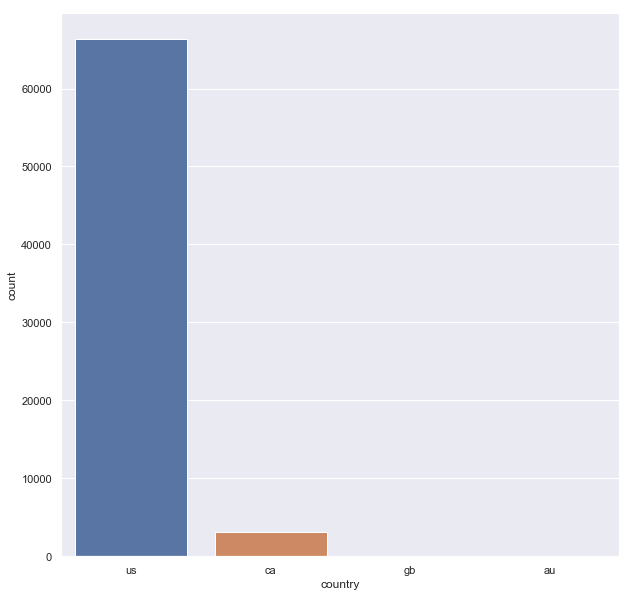

In [5]:
plt.figure(figsize=(10,10))
sns.set(style="darkgrid")
sns.countplot(x="country",
              data=raw_data,
              order=raw_data["country"].value_counts().index)

# print counts for each country
print("Country Counts:")
raw_data["country"].value_counts()

The majority of our data comes from ufo sightings reported in the US. Given that the majority of tenantbase's business is most likely done in the US, we will only use the US data points in our analysis. It also makes sense to only consider US sightings because the disparity between the US counts and the other countries' creates a class imbalance in our set that cannot be feasibly "fixed" via resampling techniques.

In [6]:
# create a new dataframe containingo only US sightings
raw_us_data = raw_data[raw_data["country"] == "us"]
print("US Data Count: ", len(raw_us_data))

# create an empty dataframe that will contain all of our cleaned data
clean_data = pd.DataFrame()

# we need to make sure that the state column only consists of strings
clean_data["state"] = raw_us_data["state"].apply(lambda x: str(x))

US Data Count:  66411


Next we plot the counts of UFO sightings per state:

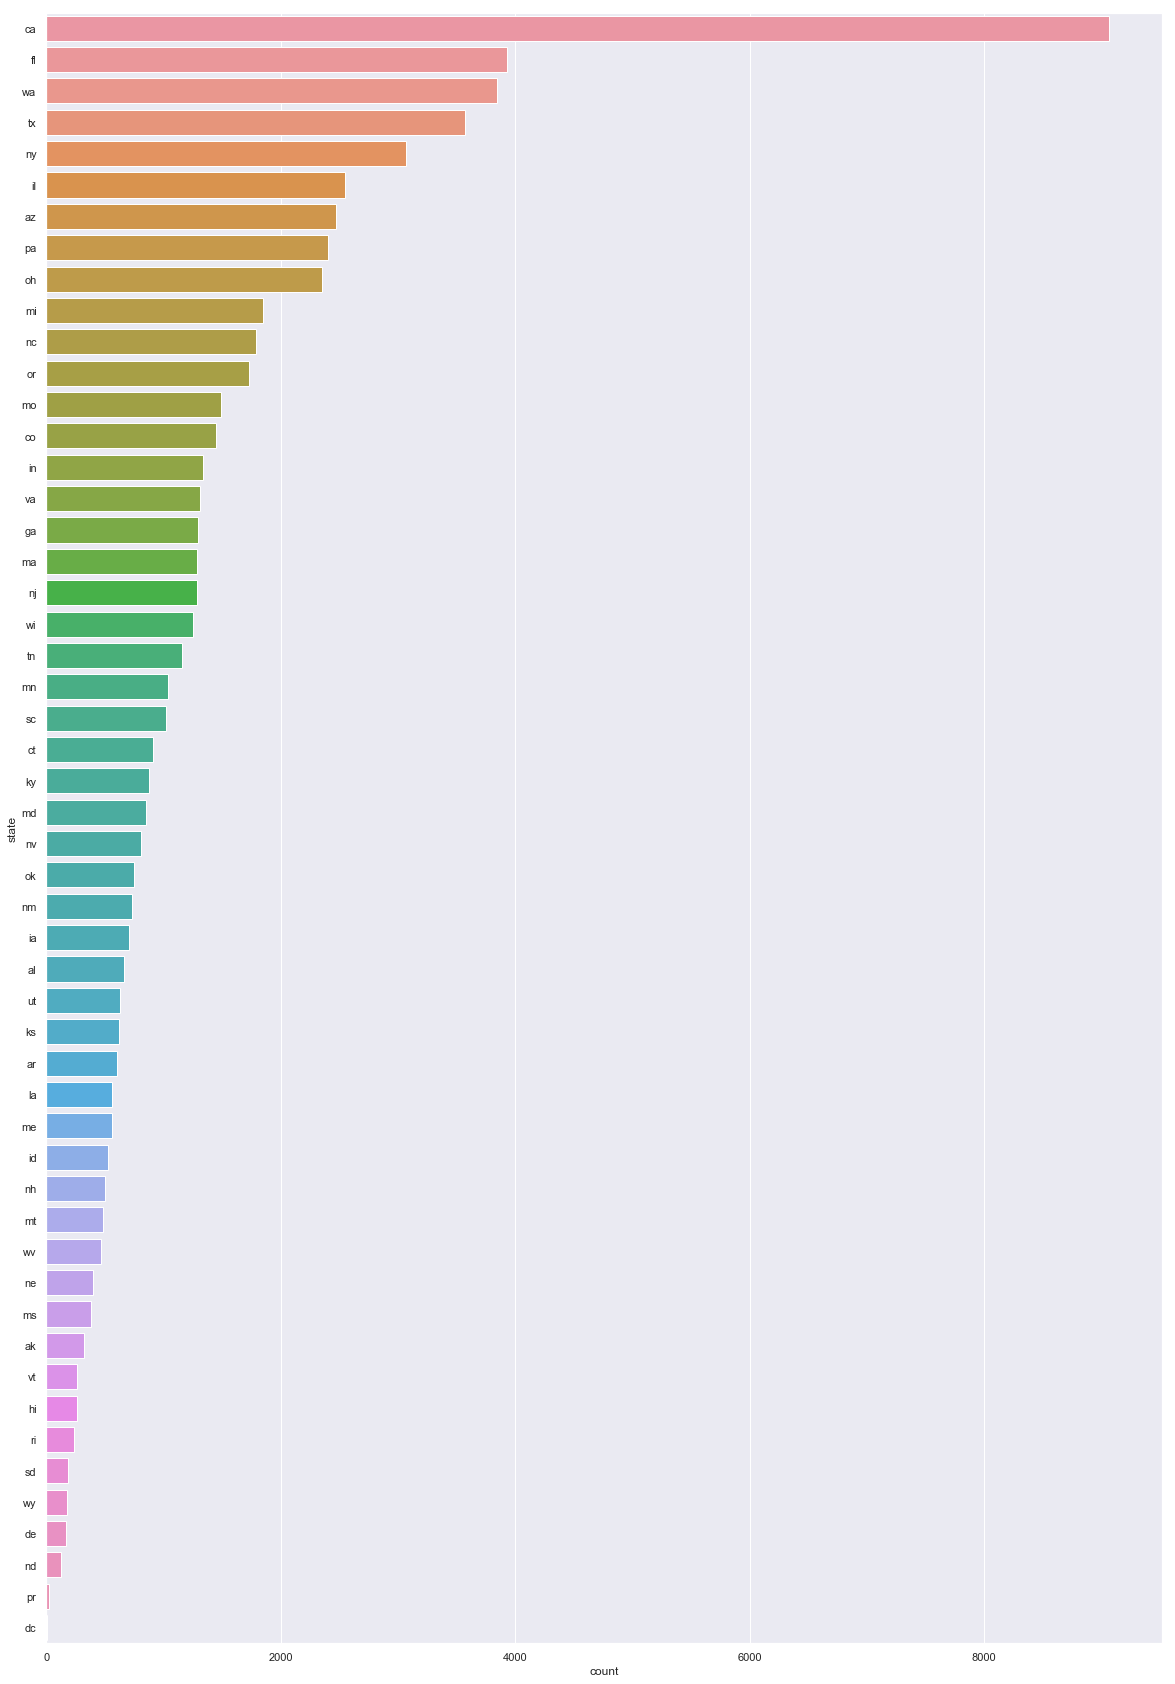

In [7]:
plt.figure(figsize=(20,30))
sns.countplot(y="state",
              data=clean_data,
              order=clean_data["state"].value_counts().index)

By far the most popular state for sightings in this data set is CA, with WA, FL, TX, and NY rounding out the top 5. The massive difference between CA counts versus other states is something we need to keep in mind since this could be due to distortions in the data (confounding factors, measurement errors, etc). This could also be due to factors such as the fact that CA has the largest population and multiple airports, whose airplanes could be confused for ufos.

### Shape

Next, we want to look at the distribution of shapes:

In [8]:
print("Number of different shapes: ", len(set(raw_us_data["shape"])))
clean_data["shape"] = raw_us_data["shape"]
clean_data["shape"].value_counts()

Number of different shapes:  28


light        14014
triangle      6788
circle        6413
fireball      5268
unknown       4924
other         4709
sphere        4468
disk          4381
oval          3173
formation     2077
cigar         1708
changing      1668
flash         1125
rectangle     1103
cylinder      1064
diamond        979
chevron        831
egg            620
teardrop       615
cone           266
cross          204
delta            6
round            2
hexagon          1
pyramid          1
crescent         1
flare            1
changed          1
Name: shape, dtype: int64

We can see that most of the shapes that occur the most are of the round/circular variety. We also see two nondescript shapes, unknown and other, showing up in the top 10 most frequently reported shapes. The shape distribution appears to be top heavy with respect to the class balance, which may cause problems down the road that we will have to address so this distribution is good to keep in mind.

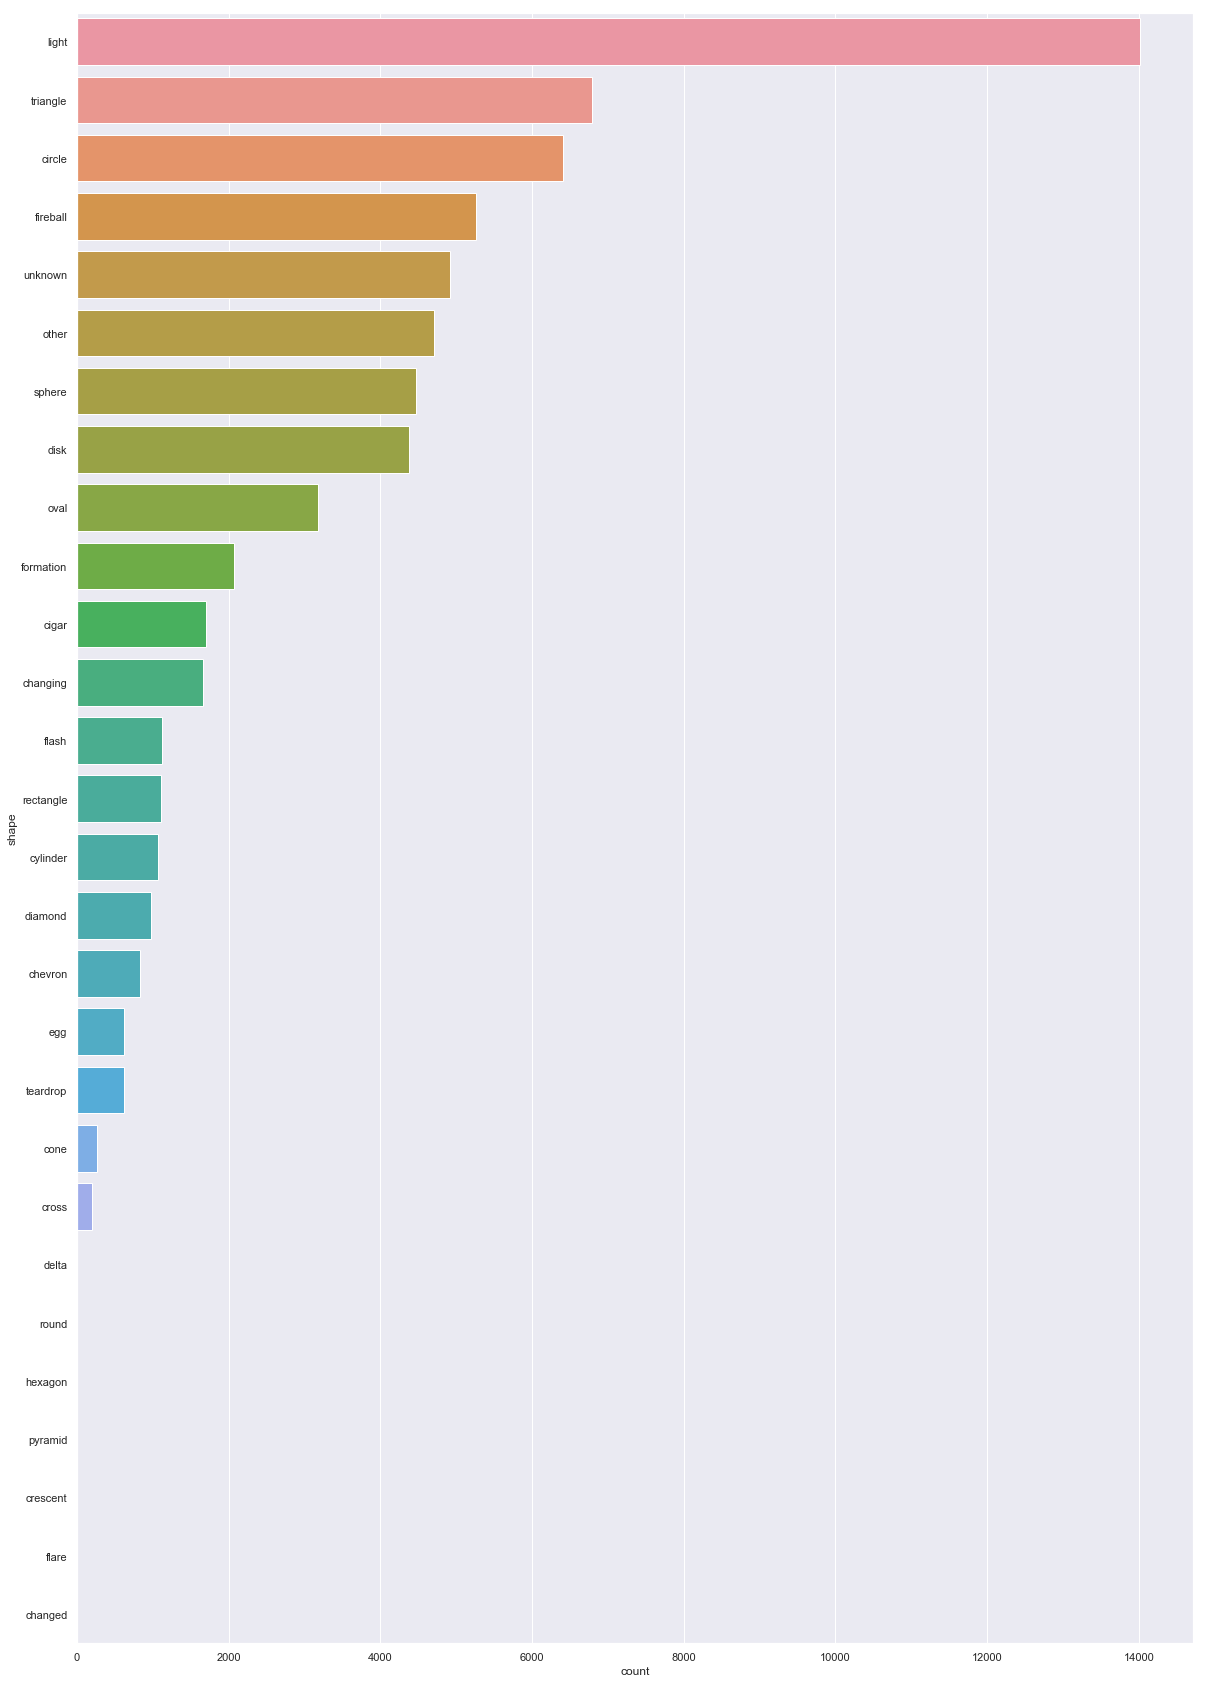

In [9]:
plt.figure(figsize=(20,30))
sns.countplot(y="shape",
              data=clean_data,
              order=clean_data["shape"].value_counts().index)



### Datetime

Next we look at the `datetime` column and split it into two variables, `month` and `hour`. We have to be careful with `datetime` here because these values are not valid when using python's built in datetime module; specifically, python's datetime objects do not recognize 24:00 as being a valid time, instead preferring 0:0, so we will need to fix those vlues in our set that contain 24:00 before proceeding further.

After we handle this issue, we peform the split by taking the hour portion of `datetime` as our new `hour` variable and taking the `month` portion as a new `month` variable, which may be useful in identifying whether or not UFO sightings vary with the seasons of the year.

In [10]:
from datetime import datetime, timedelta

# handling the 24:00 issue
# i.e. "10/10/2005 24:00" becomes "10/11/2005 0:00" 
def format_datetime(raw_time: str) -> datetime:
    try:
        time = datetime.strptime(raw_time, "%m/%d/%Y %H:%M")
    # raised when 24:00
    except ValueError:
        time = raw_time.replace(' 24', ' 23')
        time = datetime.strptime(time, "%m/%d/%Y %H:%M")
        time += timedelta(hours = 1)
        
    return time

# add the cleaned times to our clean dataframe
clean_data["datetime"] = raw_us_data["datetime"].apply(format_datetime)

# get hour and month from clean datetimes
clean_data["hour"] = clean_data["datetime"].apply(lambda x: x.hour)
clean_data["month"] = clean_data["datetime"].apply(lambda x: x.month)

clean_data.sample(10)

,state,shape,datetime,hour,month
14740,fl,unknown,2012-11-27 22:15:00,22,11
60760,tx,formation,2008-07-10 00:36:00,0,7
51541,ga,light,2002-06-10 23:10:00,23,6
79793,fl,fireball,2013-08-07 08:30:00,8,8
25190,oh,circle,2012-12-05 18:45:00,18,12
43818,nc,triangle,2012-04-28 21:00:00,21,4
38707,ca,other,2001-03-06 23:56:00,23,3
12869,de,circle,2008-11-20 23:00:00,23,11
61287,ca,triangle,1980-07-01 02:00:00,2,7
73397,ny,circle,1988-08-15 23:00:00,23,8


Using these date times, we want to analyze the time of day for these sightings. Intuitively, we would expect more sightings to occur during the night hours because of the easier visibility of the sky at night. There are other possible interactions as well, e.g. sightings reporting UFO shape as "light" should be rare since one would struggle to see lights in the day time sky.

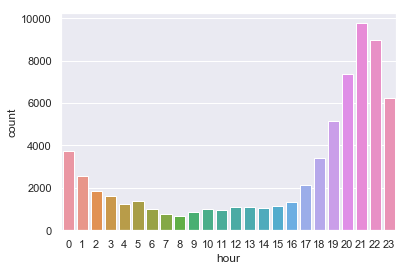

In [11]:
sns.countplot(x="hour", data=clean_data)

Unsurprisingly we observe that the number of sightings skyrockets during the night hours (~17:00 - 01:00), which makes sense given the clearness of the sky contrasted with the lights and strobes of a typical ufo. Because of this, it makes sense for us to create an indicator variable based on these time counts, where we indicate whether or not a sighting was reported to have happened during day or night hours. For our purposes, we'll consider 6:00 to 17:00 to be day hours and the other 12 hours to be night hours. Night hours will be encoded with a 1 and a 0 will be used for day hours:

In [12]:
clean_data["night"] = clean_data["hour"].apply(lambda x: 0 if x in range(6,17) else 1)
clean_data.sample(10)

,state,shape,datetime,hour,month,night
72386,ca,sphere,2007-08-12 13:00:00,13,8,0
74394,il,light,2010-08-17 01:00:00,1,8,1
24823,il,unknown,2012-12-04 22:00:00,22,12,1
10574,ma,disk,2007-11-15 23:00:00,23,11,1
20270,fl,fireball,2003-12-15 19:50:00,19,12,1
64921,wi,light,2001-07-21 22:05:00,22,7,1
36091,ca,oval,2012-03-20 14:46:00,14,3,0
24268,pa,formation,2004-01-23 04:45:00,4,1,1
6989,mo,circle,2008-10-04 04:00:00,4,10,1
8378,il,sphere,2012-01-10 19:22:00,19,1,1


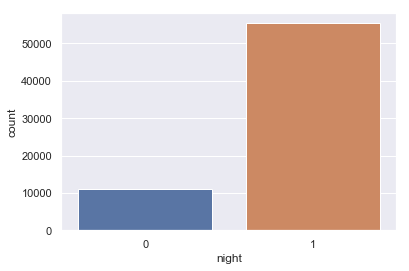

In [13]:
sns.countplot(x="night", data=clean_data)

As observed above, the majority of sightings occur at night and we're not very surprised by this result. Next we look at the distribution of `month`:

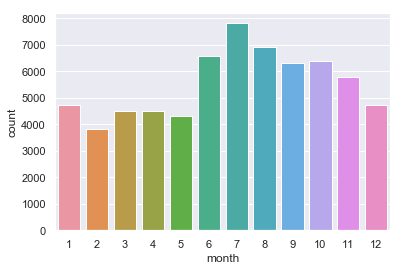

In [14]:
sns.countplot(x="month", data=clean_data)

The `month` counts look normal and relatively even, outside of months 6-8 where we observe an inflection point. This could be due to the fact that those are the summer months and people are more open to going outside during the night hours since it isn't as cold as it would be during the winter months (12-2)

It may be fruitful to see if certain shapes occur more often during the night or day:

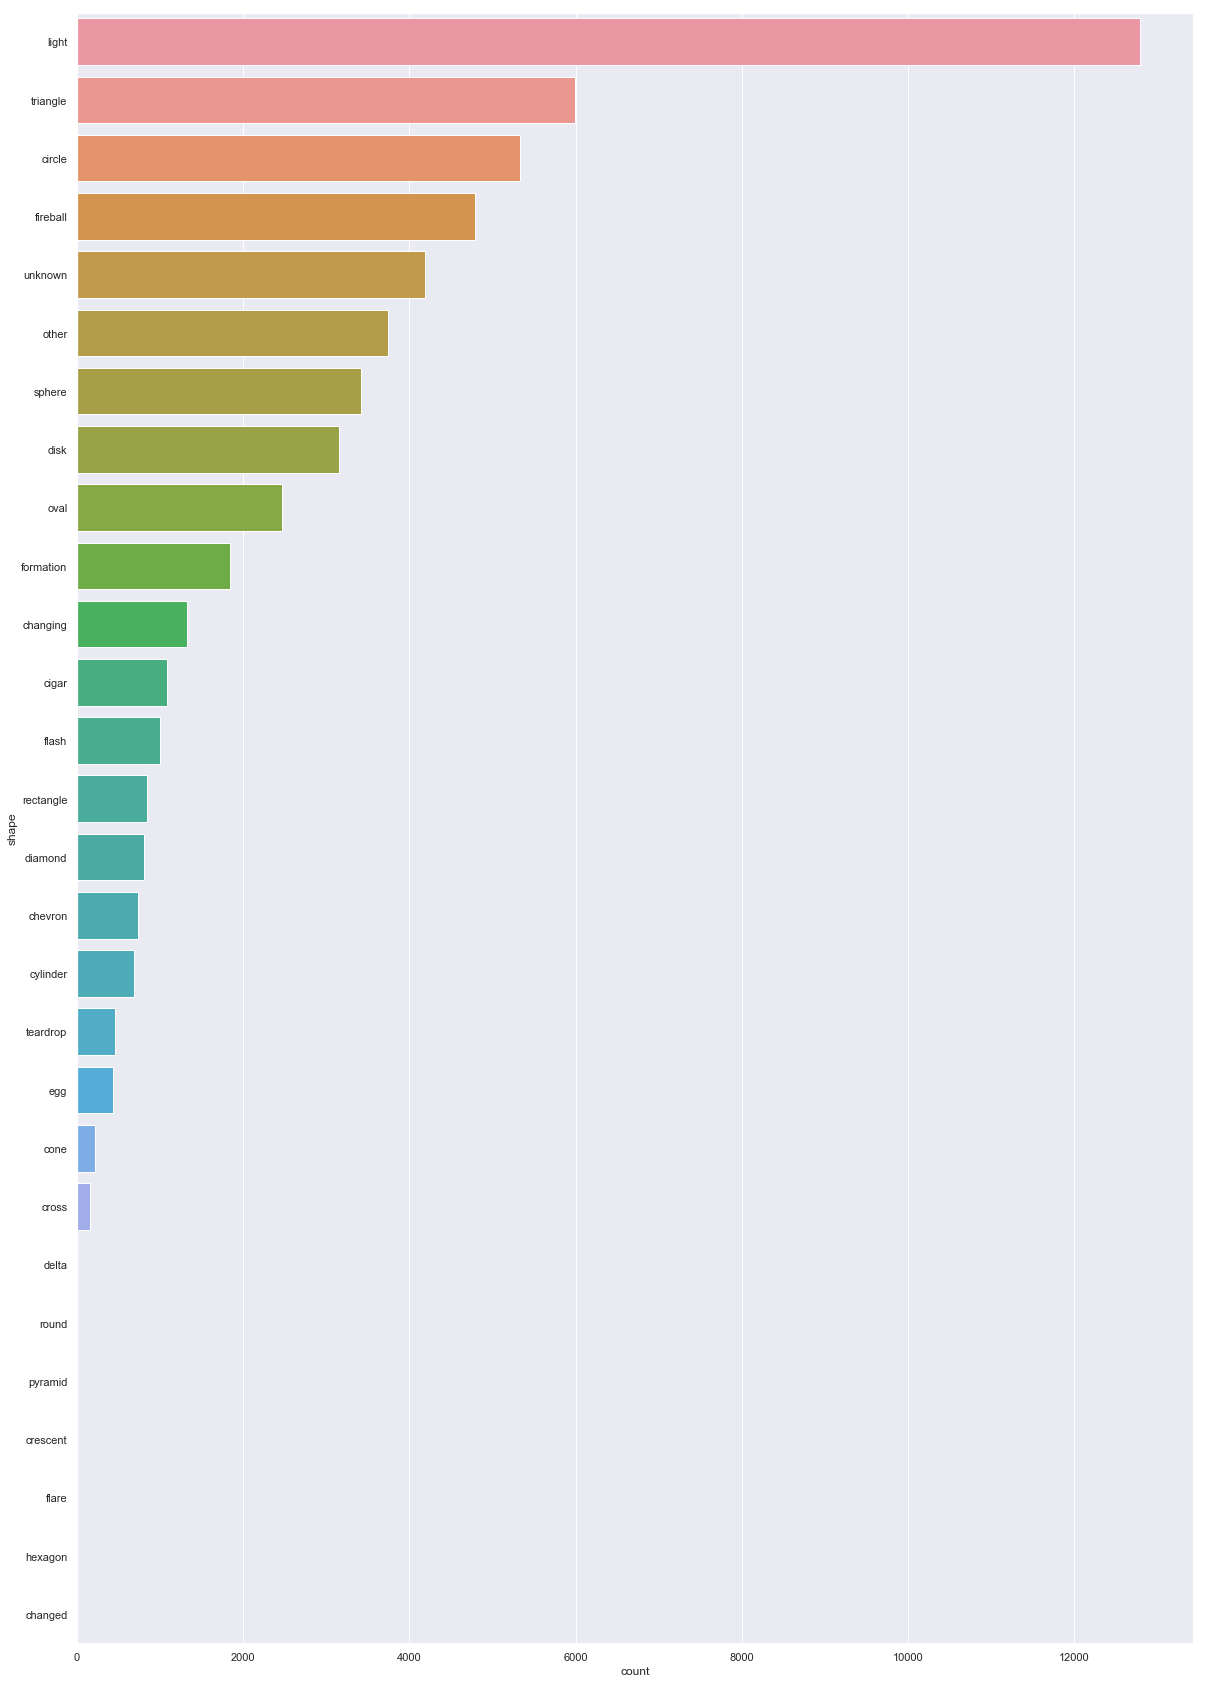

In [15]:
plt.figure(figsize=(20,30))
night_shapes = clean_data[clean_data["night"]==1]
sns.countplot(y="shape",
              data=night_shapes,
              order=night_shapes["shape"].value_counts().index)

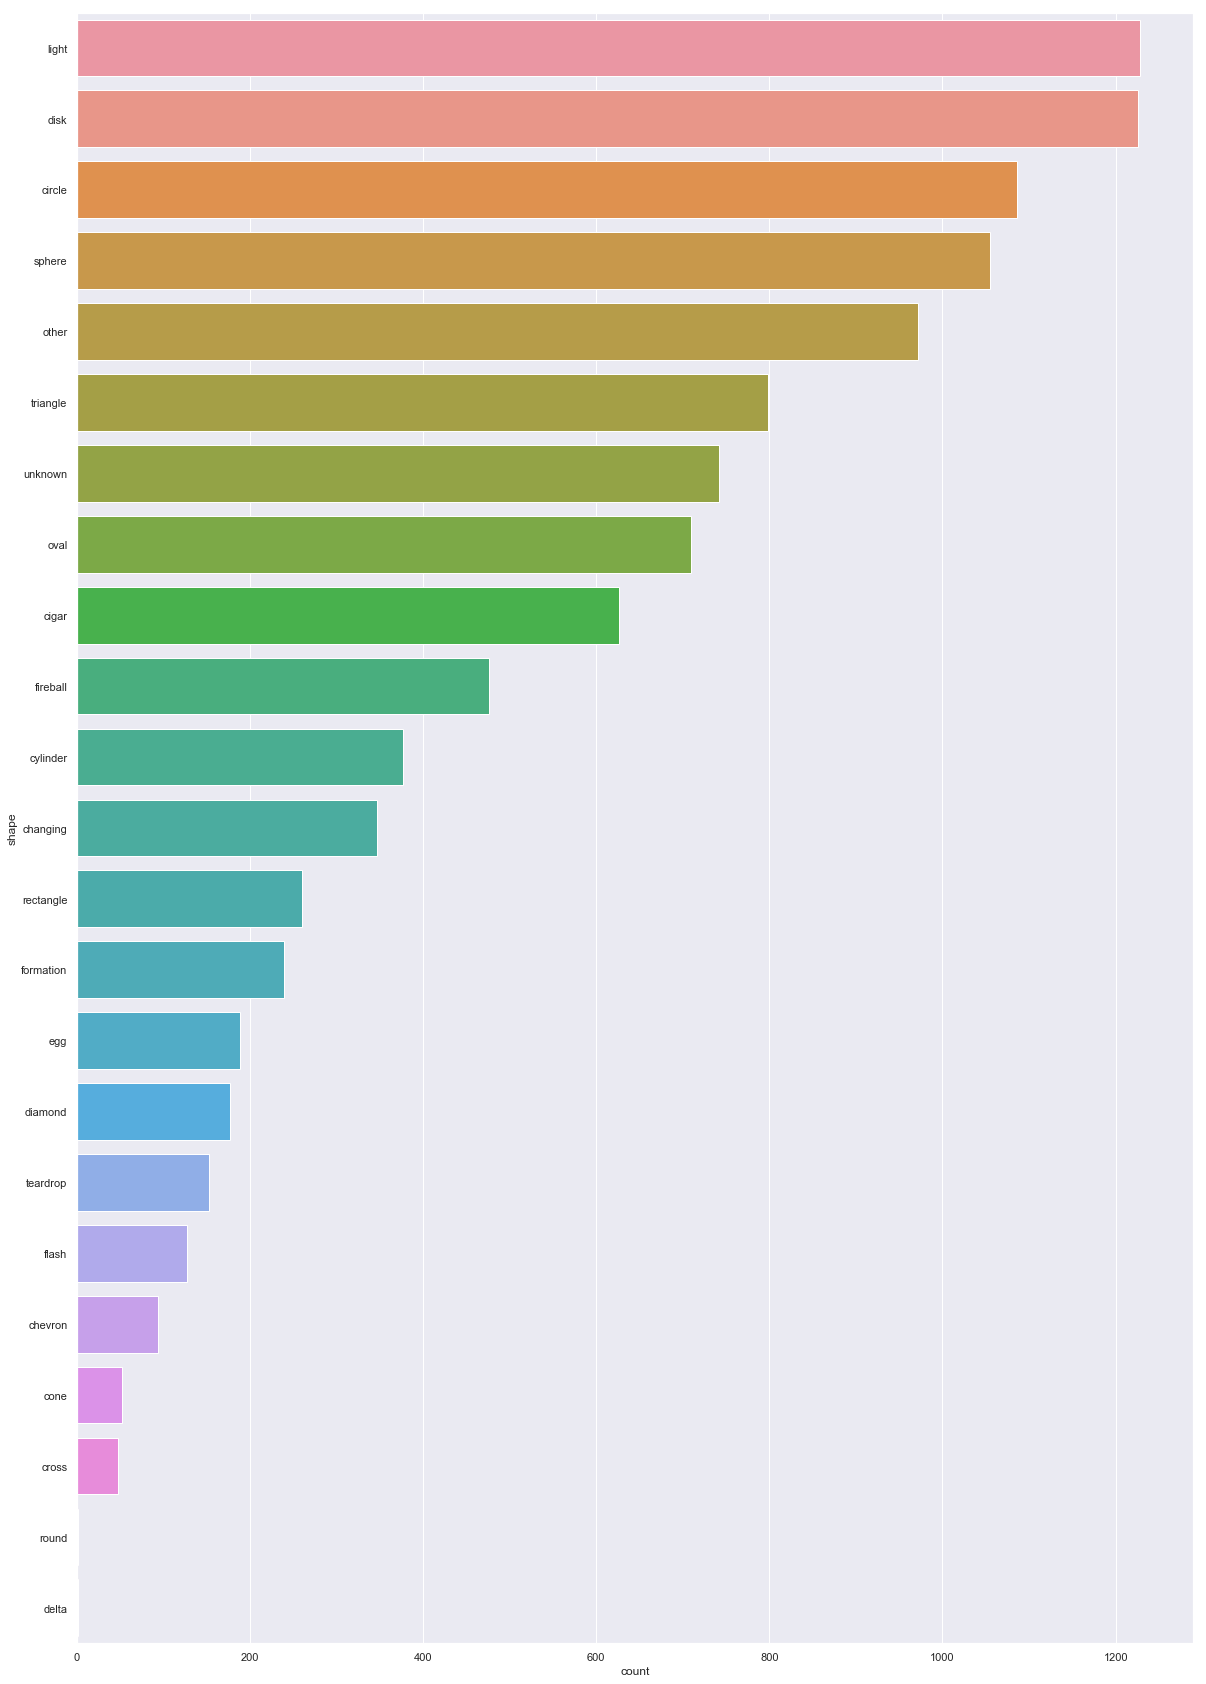

In [16]:
plt.figure(figsize=(20,30))
day_shapes = clean_data[clean_data["night"]==0]
sns.countplot(y="shape",
              data=day_shapes,
              order=day_shapes["shape"].value_counts().index)

We observe that the shapes that occur are similar for the most part, although there are some like fireball which occur less in the day and more at night which is understandable. The distribution of shapes during the day is less top heavy than the night distribution, though is mainly due to how many more night sightings we have than day sightings.

### Duration

Some of the duration values have non-numeric characters in them (letters, punctuation, etc) so we want to only extract the numbers and make sure they're integers. We use `int(float(x))` since there is at least one value in the duration column that is 0.0 which doesn't work with python's `int()` function.

In [17]:
clean_data["duration"] = raw_us_data["duration (seconds)"].apply(lambda x: int(float(x)))
clean_data.head(10)

,state,shape,datetime,hour,month,night,duration
0,tx,cylinder,1949-10-10 20:30:00,20,10,1,2700
3,tx,circle,1956-10-10 21:00:00,21,10,1,20
4,hi,light,1960-10-10 20:00:00,20,10,1,900
5,tn,sphere,1961-10-10 19:00:00,19,10,1,300
7,ct,disk,1965-10-10 23:45:00,23,10,1,1200
8,al,disk,1966-10-10 20:00:00,20,10,1,180
9,fl,disk,1966-10-10 21:00:00,21,10,1,120
10,ca,circle,1968-10-10 13:00:00,13,10,0,300
11,nc,fireball,1968-10-10 19:00:00,19,10,1,180
12,ny,disk,1970-10-10 16:00:00,16,10,0,1800


Now we have our data types in more useful formats:

In [18]:
clean_data.dtypes

state               object
shape               object
datetime    datetime64[ns]
hour                 int64
month                int64
night                int64
duration             int64
dtype: object

## Comments

It might be interesting to analyze the comments provided with each sighting and see if certain descriptions and themes characterize a general sighting.

In order to do this, we will employ multiple NLP (natural language processing) techniques to analyze this data. Because the data is textual in nature, we will need to transform the data into a quantative representation that can then be used in our modeling of the comment data. This is a process called vectorization. For our use case, we will vectorize the comments using tf-idf and use LDA (Latent Dirichlet Allocation) to model the topic distribution of the corpus of commments and determine if there are certain topics/themes that occur frequently within the data set.

The easiest explanation of LDA is that instead of looking at a corpus of documents and determining which topics are contained within the corpus, LDA models a topic distribution and assumes that documents are generated by the topics themselves, and not the other way around. This allows for a clearer separation of topics.

### Preprocessing

First we begin by cleaning our comments. This involves removing special symbols and numbers, stopwords, and words with less than 3 characters (these usually are either stopwords or have no valuable semantic information). We will also **lemmatize** and **stem** each word. Lemmatization involves taking a word and removing tense ("am" and "are" become "be"). Stemming takes a word and reduces it to its root form ("reveal" and "revealing" both become "revea"). This process helps standardize the corpus of terms present in the comments by reducing the total number of unique terms we have to deal with, and this dimensional reduction makes our LDA model work more effectively since it can better group terms together.

In [19]:
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

stemmer = SnowballStemmer("english")

def clean_text(raw: str) -> str:
    output = []
    
    for token in simple_preprocess(raw):
        if token not in STOPWORDS and len(token) > 3:
            output.append(stemmer.stem(WordNetLemmatizer().lemmatize(token,pos='v')))
            
    return ' '.join(output)

clean_data["comments"] = raw_us_data["comments"].apply(lambda x: clean_text(str(x)))

C:\Users\mathmorales\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Some examples of what the cleaning process does:

In [20]:
sample_comments = ["This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The Baptist Church sit",
                   "My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took a different route home",
                   "Slow moving&#44 silent craft accelerated at an unbelievable angle and speed."]

for comment in sample_comments:
    print("Original Comment: ", comment)
    print("Cleaned Comment: ", clean_text(comment), "\n")

Original Comment:  This event took place in early fall around 1949-50. It occurred after a Boy Scout meeting in the Baptist Church. The Baptist Church sit
Cleaned Comment:  event take place earli fall occur scout meet baptist church baptist church 

Original Comment:  My older brother and twin sister were leaving the only Edna theater at about 9 PM&#44...we had our bikes and I took a different route home
Cleaned Comment:  older brother twin sister leav edna theater bike take differ rout home 

Original Comment:  Slow moving&#44 silent craft accelerated at an unbelievable angle and speed.
Cleaned Comment:  slow move silent craft acceler unbeliev angl speed 



### Bag of Words

The Bag of Words model is a basic and popular approach in NLP. The gist of it is that we can characterize a sentence by counting the number of times a word in a sentence appears in that particular sentence. We also create a dictionary containing a unique set listing all of the words we encountered in our corpus. Using all this information, we are able to transform a sentence of words into a vector of word counts. This approach is popular because word counts are trivial to compute. 

The main downside of a BoW model is that it doesn't consider the context of a given word (i.e. the words surrounding a given word) and simply focuses on counts. Empirically, and in this particular case, it turns out that this sort of basic model works well enough in most situations. 

### tf-df

tf-idf is a vectorization method which takes into account word frequency and weights terms on how frequently or infrequently they appear. The idea is that a term that appears in almost every document contributes very little semantic information, a term that appears once or twice throughout an entire corpus probably does not contribute much either, but those terms that appear between 10-50% of the time carry the most semantic information gain. tf-idf generates term weights in accordance with these guidelines so we will use tf-df as our vectorization scheme.

In [159]:
from gensim import corpora, models
from gensim.models import LdaMulticore, CoherenceModel
import math
import pyLDAvis.gensim
pyLDAvis.enable_notebook() # allows us to visualize LDA topics

# create our dictionary
# we have to split because corpora.Dictionary
# takes a list of lists as input
dictionary = corpora.Dictionary([doc.split(' ') for doc in clean_data["comments"]])

# remove terms that appear in less than 5 documents or in more than
# 50% of documents. keep_n sets the number of terms to keep.
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# need to get our bow representation before we apply a tfidf transformation on it
bow_corpus = [dictionary.doc2bow(doc.split(' ')) for doc in clean_data["comments"]]
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# train our lda model using a baseline of 10 topics
lda_model = LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=4, workers=4)

# display our topics
pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      13.168978        1       1  0.099828 -0.041059
5      11.462125        1       2  0.030545 -0.039762
2      11.054065        1       3 -0.233269 -0.028420
0      10.036245        1       4  0.113134 -0.037455
8       9.871947        1       5  0.018029 -0.025415
6       9.598511        1       6  0.050734 -0.072964
7       9.430188        1       7  0.000856  0.034672
4       8.603156        1       8  0.016871  0.260843
3       8.456680        1       9  0.019751 -0.023668
9       8.318104        1      10 -0.116481 -0.026772, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
17    Default   880.000000          quot   880.000000  30.0000  30.0000
295   Default   676.000000          note   676.000000  29.0000  29.0000
296   Default   668.000000        nuforc   668.000000  28.0000  28.0000
297   Default   403.000000       possibl   403.000000  27.0000  27.0000
85    Default  1117.000000         sight  1117.000000  26.0000  26.0000
141   Default  1154.000000          star  1154.000000  25.0000  25.0000
522   Default   295.000000        counti   295.000000  24.0000  24.0000
39    Default   811.000000         speed   811.000000  23.0000  23.0000
96    Default   392.000000          tree   392.000000  22.0000  22.0000
22    Default   682.000000         chang   682.000000  21.0000  21.0000
156   Default   787.000000          high   787.000000  20.0000  20.0000
495   Default   241.000000      daylight   241.000000  19.0000  19.0000
252   Default  1060.000000       triangl  1060.000000  18.0000  18.0000
9     Default   329.000000          home   329.000000  17.0000  17.0000
986   Default   240.000000          juli   240.000000  16.0000  16.0000
455   Default   239.000000          rate   239.000000  15.0000  15.0000
407   Default  1030.000000       firebal  1030.000000  14.0000  14.0000
58    Default   463.000000        silver   463.000000  13.0000  13.0000
432   Default   223.000000           ufo   223.000000  12.0000  12.0000
203   Default   324.000000        outsid   324.000000  11.0000  11.0000
23    Default   848.000000         color   848.000000  10.0000  10.0000
452   Default   210.000000         peopl   210.000000   9.0000   9.0000
69    Default   938.000000          look   938.000000   8.0000   8.0000
256   Default   220.000000    california   220.000000   7.0000   7.0000
105   Default   343.000000        report   343.000000   6.0000   6.0000
327   Default   174.000000    washington   174.000000   5.0000   5.0000
258   Default   406.000000         drive   406.000000   4.0000   4.0000
351   Default   173.000000         venus   173.000000   3.0000   3.0000
530   Default   203.000000         ocean   203.000000   2.0000   2.0000
421   Default   211.000000          ohio   211.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
685   Topic10    45.233965        outlin    50.209349   2.3824  -5.6128
379   Topic10   114.861044          land   159.223445   2.1602  -4.6809
253   Topic10    51.150356         dozen    58.443085   2.3535  -5.4899
2     Topic10   191.833675          fall   319.657016   1.9761  -4.1680
31    Topic10   202.357501        saucer   401.045703   1.8027  -4.1146
462   Topic10    52.893500          camp    61.609698   2.3342  -5.4564
121   Topic10    69.093210  neighborhood    96.204591   2.1557  -5.1892
232   Topic10   185.005803          spot   548.223147   1.4004  -4.2043
585   Topic10    75.788604          late   122.096673   2.0099  -5.0967
146   Topic10   163.976245           wit   581.252177   1.2213  -4.3249
97    Topic10   196.225932          ball   901.903240   0.9615  -4.1454
213   Topic10   128.354152         cigar   417.839771   1.3064  -4.5699
57    Topic10   225.599504           see  1433.974270   0.6373  -4.00

The way we interpret this plot is that each circle represents a different "topic". In the LDA model, topics are represented as a linear combination of words that occur often in that particular topic:

In [160]:
# print the terms and weights for each topic
# the idx+1 corrects for the fact that 
# ldavis plots topics starting at 1 but
# lda generates topics with 0 as the first
for idx, topic in lda_model.print_topics():
    print("Topic: {} \n Word: {} \n\n".format(idx+1, topic))

Topic: 1 
 Word: 0.027*"move" + 0.027*"color" + 0.027*"chang" + 0.026*"object" + 0.026*"light" + 0.022*"shape" + 0.021*"bright" + 0.019*"fast" + 0.015*"hover" + 0.015*"orang" 


Topic: 2 
 Word: 0.045*"light" + 0.036*"orang" + 0.032*"triangl" + 0.029*"bright" + 0.026*"white" + 0.022*"flash" + 0.021*"glow" + 0.021*"shape" + 0.021*"format" + 0.020*"craft" 


Topic: 3 
 Word: 0.019*"look" + 0.017*"home" + 0.017*"strang" + 0.016*"drive" + 0.016*"outsid" + 0.015*"notic" + 0.013*"friend" + 0.013*"object" + 0.012*"sit" + 0.012*"light" 


Topic: 4 
 Word: 0.023*"tree" + 0.017*"juli" + 0.016*"light" + 0.014*"object" + 0.013*"bright" + 0.012*"line" + 0.012*"minut" + 0.012*"follow" + 0.011*"circl" + 0.011*"orang" 


Topic: 5 
 Word: 0.050*"note" + 0.050*"nuforc" + 0.041*"sight" + 0.031*"firebal" + 0.028*"possibl" + 0.016*"report" + 0.015*"star" + 0.014*"light" + 0.013*"washington" + 0.013*"venus" 


Topic: 6 
 Word: 0.023*"east" + 0.022*"move" + 0.021*"west" + 0.019*"light" + 0.017*"north" + 0.01

For example, in topic 1, we see that the dominant terms characterize the sightings that fall into this topic as being "color move change object bright fast". Topic 9 tells us that we have a category of sightings that are described as being something like "high speed bright light object". Looking at our topic plot, we can cut it into 3 different clusters: one for topic 8, one for topics 10 and 3, and one containing all the overlapping topics in the bottom right. Each cluster represents a different type of experience and using this LDA model we can classify each comment into a different cluster and use cluster number as a numerical feature in our classifier.

For now, we will refrain from using cluster number as a feature unless our classifier performs poorly and we want to prepare another feature for it. Adding cluster number before we train an initial model may add too much noise and we want to iteratively build a model from basic features before we begin incorporated new engineered features.

# Feature Engineering

If we wish to create a classifier to predict the shape of a ufo given certain features, we need to decide which features from the data set we will use. The following are features that we will exclude from our model based on our analysis above:

* **Datetime and Date Posted**: Because we're not modeling time series data, we will refrain from using date features in order to avoid cluttering our feature space. However, we will use the `night` and `month` variables we created earlier since this may contain useful information for our classifier.
* **City**: We refrain from using city as a feature because including city would cause our feature space to blow up in size for very little information gain in return. Additionally, we have state and latitude/longitude features which serve the same purpose but better. In a larger data set, we would expect city and lat/long features to be collinear so it's best to just exclude the city feature.
* **Duration (hours/min)**: The duration (seconds) feature is better since all of the durations are in the same unit and easy to standardize as we did above.
* **Latitude and Longitude**: These variables could be useful if we had access to more geographic style features (i.e. coordinates of nearby airports) but for our purposes, the `state` variable is more than enough. We want to avoid having our feature space blow up in size.

Thus the feature set for our model consists of:

* Time
* State
* Duration (seconds)
* Comments

Since `state` and `shape` are categorical, we will need to encode them as indicator variables for use with our classifier. For `state`, we will use one-hot encoding which creates a column for each state value and contains a 1 if a sighting took place in that particular state. For `shape`, we will use sklearn's `LabelEncoder()` method since we want one single column as our target column for our training/testing phases.

In [24]:
from sklearn.preprocessing import LabelEncoder

# label encoder for `shape`
shape_encoder = LabelEncoder().fit(clean_data["shape"])
clean_data["shape_enc"] = shape_encoder.transform(clean_data["shape"])

# encode our `state` variable using one-hot
clean_data = pd.get_dummies(clean_data, columns=["state"])

clean_data.sample(10)

,shape,datetime,hour,month,night,duration,comments,shape_enc,state_ak,state_al,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
60495,light,2009-06-09 23:59:00,23,6,1,60,bright star like light travel close speed dim ...,18,0,0,...,0,0,0,0,0,0,1,0,0,0
78229,formation,1997-08-31 17:00:00,17,8,1,5400,static format metal sphere observ peopl clear ...,16,0,0,...,0,0,0,0,0,0,0,0,0,0
40026,oval,2007-04-01 21:36:00,21,4,1,300,object move round straighter rear foot grind move,20,0,0,...,0,0,0,0,0,0,0,0,0,0
40679,light,2013-04-14 00:30:00,0,4,1,3600,group orang light castl,18,0,0,...,0,0,0,0,0,0,0,0,0,0
25562,circle,2013-12-06 20:00:00,20,12,1,60,blue green circular light see texa storm,4,0,0,...,0,0,1,0,0,0,0,0,0,0
52416,circle,1983-06-01 21:30:00,21,6,1,600,monstrous round silent,4,0,0,...,0,0,0,0,0,0,0,0,0,0
949,disk,2008-10-01 01:00:00,1,10,1,5,larg metal object hover grind short beam come ...,11,0,0,...,0,0,0,0,0,0,0,0,0,0
56808,light,2004-06-23 01:50:00,1,6,1,1080,bright light see night time dim intens time di...,18,0,0,...,0,0,0,0,0,0,1,0,0,0
71169,light,2008-08-10 00:15:00,0,8,1,4500,white light show color chang intermitt,18,0,0,...,0,0,0,0,0,0,0,0,0,0
88547,teardrop,2006-09-09 23:00:00,23,9,1,2,small silver teardrop long skinni tail vanish ...,25,0,0,...,0,0,0,0,0,0,0,0,0,0


# Modelling

Because we are trying to use features from the data set to predict the `shape` column, we have a supervised classification problem on our hands. This type of learning is called supervised because we have a label (`shape`) so we know what the correct answer for a given training example should be and our classifier uses this the disparity between what it predicts for a label and what the label actually is in order to learn. Below, we choose our desired features and preview what our feature set looks like:

In [26]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# features
# we use .drop to remove columns and only leave the
# columns we're interested in using as features
X = clean_data.drop(['shape','datetime', 'shape_enc','comments'],axis=1)
y = clean_data["shape_enc"]

print("Our Feature Set: ")
X.head(10)

Our Feature Set: 


,hour,month,night,duration,state_ak,state_al,state_ar,state_az,state_ca,state_co,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,20,10,1,2700,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,21,10,1,20,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,20,10,1,900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,19,10,1,300,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,23,10,1,1200,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,20,10,1,180,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,21,10,1,120,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,13,10,0,300,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11,19,10,1,180,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,16,10,0,1800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Next, we split our feature set into a training set to be used in training our models and a testing set for evaluating the performance of our model. We will use `test_size=0.2` to partition our clean_data set: 80% of the data will be used in our training set and the remaining 20% will be used in our testing set.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=21)

### Linear Discriminant Analysis

The first model we'll try is a Linear Discriminant Analysis model (not to be confused with the other LDA from above). This is a standard model used for multiclass supervised learning problems such as this one.

In [28]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train)
print("Accuracy Score: ", lda.score(X_test, y_test))

Accuracy Score:  0.20590228111119477


C:\Users\mathmorales\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


We observe an accuracy score of 0.2, which isn't very good. However, we have to be careful not to place too much stock into accuracy scores since precision and recall are other important metrics to consider. Precision and recall measure the false positive and false negative rates; we will visualize these during the model evaluation section when we look at what's called a **confusion matrix**.

### Gradient Boosting

The next model we will try is a gradient boosted decision tree. What is gradient boosting? The long and short of it is that gradient boosting creates an assortment of weak models, i.e. models trained on random subsets of the feature set, and iteratively combines these weak models until we arrive at a stronger model which we will use as our classifier. We choose to boost a decision tree because decision tree classifiers are fast and empirically perform well.

In [29]:
import xgboost as xgb

# transform our pandas dataframe of features
# into an array for use with the xgboost library
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

params = {
    'max_depth': 3, # maximum depth of all trees
    'eta': 0.3, # step size during each iteration
    'objective': 'multi:softmax', # function classifier optimizes to determine class
    'num_class': len(set(clean_data["shape"])) # number of classes used in predictions
}

# number of training iterations
num_round=20

tree = xgb.train(params, xgb_train, num_round)

# Model Evaluation

Our first step in the evaluation of our model will be to look at the confusion matrix for our classifiers. A confusion matrix is simply a visual representation of the true positives, false positives, etc that occurred during our model's testing phase. This visual representation allows us have some ideas about where the model is failing, i.e. not being able to predict certain shapes because of lack of data/entropy gain from our features, determining if the model is leaning towards more false positives then false negatives.

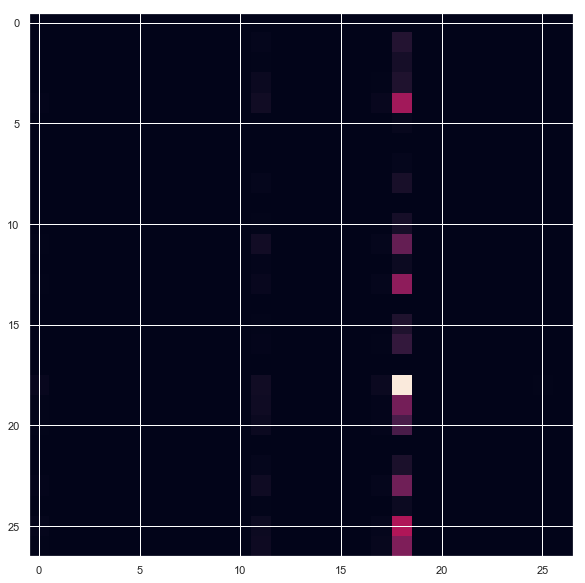

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# function we'll use to plot confusion matrices
def plot_confusion(cm_map):
    plt.figure(figsize=(10,10))
    plt.imshow(cm_map, interpolation='nearest')
    plt.xticks = np.arange(cm_map.shape[1])
    plt.yticks = np.arange(cm_map.shape[0])
    plt.show()
    
# first we need to get predictions from our classifier for 
# our train set
y_lda_pred = lda.predict(X_test)

# create a confusion matrix by comparing our predicted
# values to the actual values of y_test
cm_lda = confusion_matrix(y_test, y_lda_pred)

plot_confusion(cm_lda)

When we look at a confusion matrix, we evaluate the information by looking at the heatmap of values. The Y-axis represents the True Label value and the X-axis represents the Predicted Label value. Lighter shading implies more predictions fell into that cell. Shaded values along the top-left to bottom-right diagonal indicate that those classes are being correctly predicted, i.e. if we think of our predictions and test values as being (predicted,actual), shading in the coordinate (5,5) indicates that we guessed class 5 and were correct for many test observations. As we can see, the lightest cell lies at the coordinate (18,18), which indicates that we predicted all the obsevations that were actually in class 18 correctly.

For a "good" confusion matrix, we want our shaded values to be distributed mainly along the main diagonal of the matrix. Shaded values that occur off-diagonal indicate either false positives or false negatives which mean that our classifier made an incorrect prediction.

The linear discriminant analysis model we trained is predicting a ufo shape of 18 for most observations, which tells us that it's not looking at the features and simply determined during the optimization of its objective function that predicting 18 most of the time is the optimal strategy. We can check and see what shape 18 corresponds to:

In [84]:
shape_encoder.inverse_transform(18)

C:\Users\mathmorales\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'light'

Next, we look at the confusion matrix for our boosted classifier:

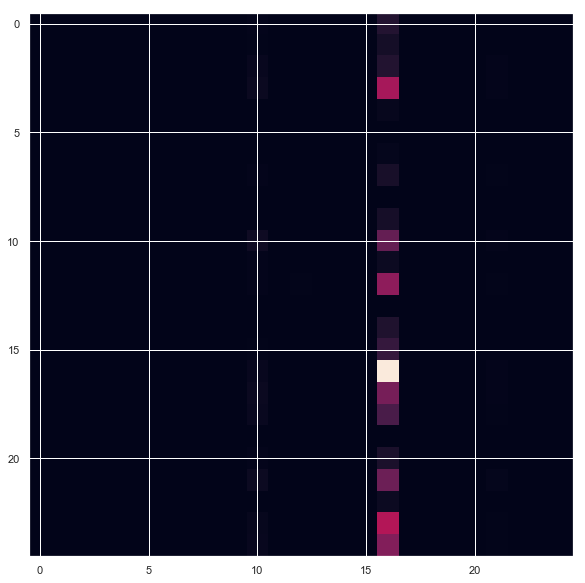

In [85]:
tree_pred = tree.predict(xgb_test)
cm_tree = confusion_matrix(y_test, tree_pred)

plot_confusion(cm_tree)

Here we observe the same issue. Because light is such a dominant shape in our data set, guessing light for most observations regardless of features yields a better accuracy score than trying to predict shape from the features. This is an indication of two issues:

* The features are independent of the target such that they provide little information gain, i.e. the date a sighting was posted provides very little information on what the shape of the ufo observed was.
* The imbalance of our shape distribution is causing our classifier to simply return whatever the most common class is as its prediction.

With this particular data set, because of the independence of variables and the fact that there is low information gain between the different features and the `shape` variable, the classifier's optimal strategy is to guess the most common shape present in the data because this yields a higher accuracy than making naive predictions by assuming that shapes take on a uniform distribution and guess from that set. Recall that we have 28 unique shape values; for 28 shapes, the naive accuracy we would get by guessing a random shape is 1/28 = 0.035. The accuracy scores we receieved from our two trained classifiers are much better than 0.035 so the classifier is correct in thinking that guessing light for every observation leads to a better accuracy score.

What now? In this case, if we return to the distribution of shape counts from above, we see that the majority of the shapes in the set have a low number of counts and that the shape `light` accounts for an overwhelming amount of shapes in the set. Because of this class imbalance and the independence of our features, we have reached an impasse. We have a few options before us:

* **Balancing the `shape` class distribution**: With this shape distribution, we cannot use resampling methods to balance the classes because the shape distribution is too top heavy and we don't have enough observations in the bottom half.
* **Creating a new variable where we bin our `shapes`**: Part of the problem is that many of the rarer shapes in our set are merely different ways of describing a shape that appears in the more common half of the distribution, e.g circle, disk, sphere show up often in sightings but round is rare even though it is a similar sort of shape. In this situation, it may make more sense to create groups of shapes and attempt predicting these groups instead. This will reduce the number of classes we have to deal with and help with our unbalanced classes problem.

We will be binning our shapes as follows:

* **Round:** This bin will consist of circle, oval, disk, teardrop, cylinder, sphere, egg, round
* **Light:** This bin will consist of flare, light, fireball, flash
* **Triangle:** This bin will consist of pyramid, delta, triangle, chevron, cone, diamond
* **Polygon:** This bin will consist of shapes that dont easily fall into the other bins, such as crescent, cigar, cross, formation, hexagon, and rectangle.
* **Other:** This bin contains the nondescript shapes: other, changed, changing, unknown

In [86]:
def bin_shapes(shape: str) -> str:
    
    if shape in ['circle','oval','disk','teardrop','cylinder','sphere','egg','round']:
        return 'round'
    elif shape in ['flare','light','fireball','flash']:
        return 'light'
    elif shape in ['pyramid','delta','triangle','chevron','cone','diamond']:
        return 'triangle'
    elif shape in ['crescent','ciger','cross','formation','hexagon','rectangle']:
        return 'polygon'
    else:
        return 'other'
    
clean_data['shape_bin'] = clean_data['shape'].apply(bin_shapes)

clean_data[['shape','shape_bin']].sample(20)

,shape,shape_bin
17720,triangle,triangle
82442,cigar,other
72062,sphere,round
60336,sphere,round
4835,circle,round
88197,triangle,triangle
34455,circle,round
24163,disk,round
34739,unknown,other
23885,circle,round


Now we check the balance of our bin classes:

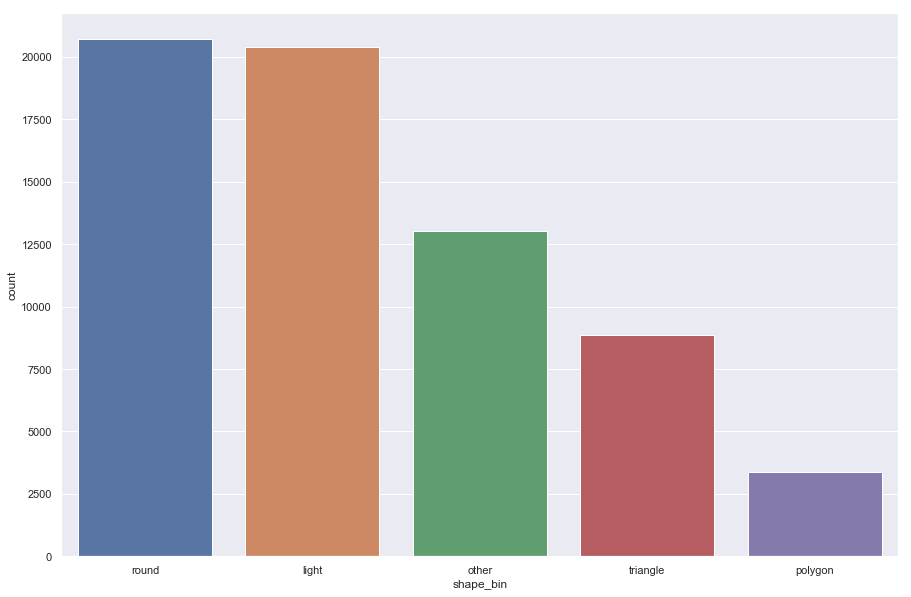

In [87]:
plt.figure(figsize=(15,10))
sns.countplot(x="shape_bin",
              data=clean_data,
              order=clean_data["shape_bin"].value_counts().index)

We observe that our classes are much more balanced now and that polygon is the only fairly underrepresented class. Now we can try training our classifier again:

In [88]:
clean_data.head(5)

,shape,datetime,hour,month,night,duration,comments,shape_enc,state_ak,state_al,...,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy,shape_bin,shape_bin_enc
0,cylinder,1949-10-10 20:30:00,20,10,1,2700,event take place earli fall occur scout meet b...,8,0,0,...,1,0,0,0,0,0,0,0,round,3
3,circle,1956-10-10 21:00:00,21,10,1,20,older brother twin sister leav edna theater bi...,4,0,0,...,1,0,0,0,0,0,0,0,round,3
4,light,1960-10-10 20:00:00,20,10,1,900,marin fli fighter attack aircraft solo night e...,18,0,0,...,0,0,0,0,0,0,0,0,light,0
5,sphere,1961-10-10 19:00:00,19,10,1,300,father brother girl fellow work father livi,24,0,0,...,0,0,0,0,0,0,0,0,round,3
7,disk,1965-10-10 23:45:00,23,10,1,1200,bright orang color chang reddish color disk sa...,11,0,0,...,0,0,0,0,0,0,0,0,round,3


In [130]:
# create encoded variable for shape_bin
shape_bin_encoder = LabelEncoder().fit(clean_data["shape_bin"])
clean_data["shape_bin_enc"] = shape_bin_encoder.transform(clean_data["shape_bin"])

# create our feature set
X_bin = clean_data.drop(["shape","datetime","comments","shape_enc","shape_bin", "shape_bin_enc"],axis=1)

# create a new target variable with `shape_bin`
y_bin = clean_data["shape_bin_enc"]

X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y_bin, test_size=0.2, random_state=42)

print("Our Feature Set: ")
X.head(10)

Our Feature Set: 


,hour,month,night,duration,state_ak,state_al,state_ar,state_az,state_ca,state_co,...,state_sd,state_tn,state_tx,state_ut,state_va,state_vt,state_wa,state_wi,state_wv,state_wy
0,20,10,1,2700,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,21,10,1,20,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,20,10,1,900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,19,10,1,300,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,23,10,1,1200,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,20,10,1,180,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,21,10,1,120,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,13,10,0,300,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11,19,10,1,180,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,16,10,0,1800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
# train our linear discriminant classifier
lda_bin = LinearDiscriminantAnalysis()
lda_bin.fit(X_bin_train,y_bin_train)
print("Accuracy Score: ", lda_bin.score(X_bin_test, y_bin_test))

Accuracy Score:  0.3532334562975232


C:\Users\mathmorales\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


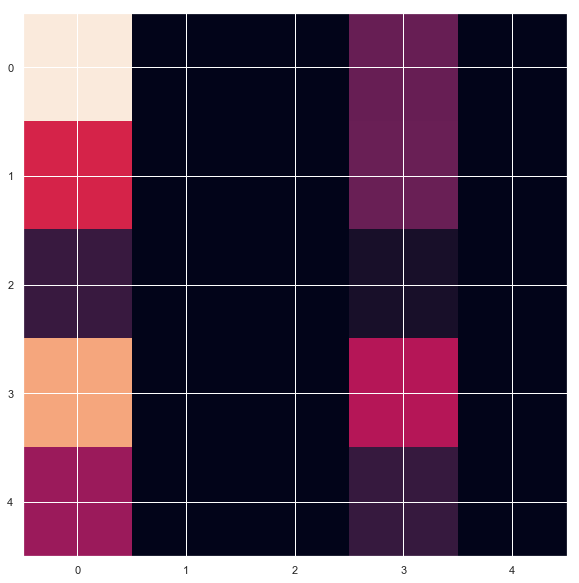

In [132]:
lda_bin_pred = lda_bin.predict(X_bin_test)
cm_lda_bin = confusion_matrix(y_bin_test, lda_bin_pred)

plot_confusion(cm_lda_bin)

With our binned shape variable, our lda classifier's accuracy increases by 0.15 and we no longer observe the classifier predicting the most common shape repeatedly, a promising sign. However, now it looks like the classifier is guessing between two different shape types. Now we train another boosted classifier:

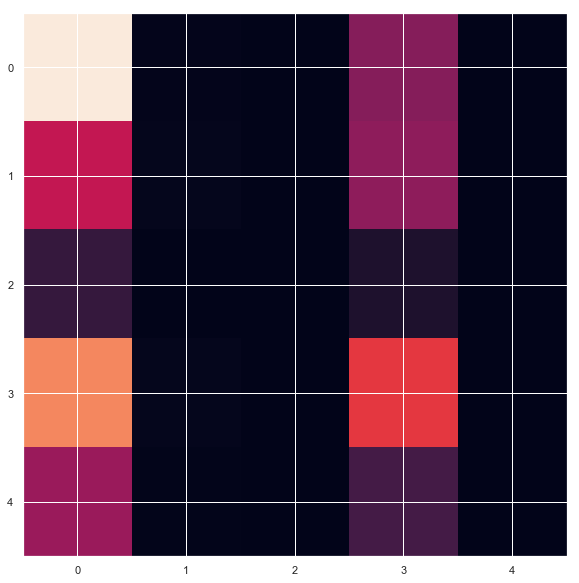

In [133]:
xgb_bin_train = xgb.DMatrix(X_bin_train, label=y_bin_train)
xgb_bin_test = xgb.DMatrix(X_bin_test, label=y_bin_test)

params = {
    'max_depth': 3, # maximum depth of all trees
    'eta': 0.3, # step size during each iteration
    'objective': 'multi:softmax', # function classifier optimizes to determine class
    'num_class': len(set(clean_data["shape"])) # number of classes used in predictions
}

# number of training iterations
num_round=30

tree_bin = xgb.train(params, xgb_bin_train, num_round)

tree_bin_pred = tree_bin.predict(xgb_bin_test)

cm_bin_xgb = confusion_matrix(y_bin_test, tree_bin_pred)

plot_confusion(cm_bin_xgb)

In [136]:
from sklearn.metrics import precision_score

error_rate_bin = np.sum(tree_bin_pred != y_bin_test) / y_bin_test.shape[0]
print('Test error = {}'.format(error_rate_bin))
print('Precision Score = {}'.format(precision_score(y_bin_test, tree_bin_pred, average='macro')))

Test error = 0.632537830309418
Precision Score = 0.21045830234881527


C:\Users\mathmorales\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Similar result. We see that we have a precision score of 0.21, which means that we are misclassifying many observations as being positive when they're actually negative for that class, i.e. many false positives. We are only really able to perform accurate predictions for shape bins 0 and 3. These are:

In [135]:
print("Bin 0: ", shape_bin_encoder.inverse_transform(0))
print("Bin 3: ", shape_bin_encoder.inverse_transform(3))

Bin 0:  light
Bin 3:  round


C:\Users\mathmorales\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\mathmorales\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


As expected, we see that the two classes we are able to get any sort of accuracy for are the two binned classes that are the most well represented, light and round. At this point, in an effort to produce a classifier that can be used on a reduced form of the feature set, we will create a reduced model where we will only consider observations with a shape bin value of light or round. We will also drop our encoded state values since these are not adding anything to our classifier's accuracy.

### Reduced Model

In [144]:
clean_data_reduced = clean_data[clean_data["shape_bin"].isin(["round","light"])]
X_reduced = clean_data_reduced[["hour","month","night","duration"]]
y_reduced = clean_data_reduced["shape_bin_enc"]

X_reduced_train, X_reduced_test, y_reduced_train, y_reduced_test = train_test_split(X_reduced, y_reduced, test_size=0.2, random_state=42)

X_reduced.head(5)

,hour,month,night,duration
0,20,10,1,2700
3,21,10,1,20
4,20,10,1,900
5,19,10,1,300
7,23,10,1,1200


In [146]:
from xgboost import XGBClassifier

num_round=30
bst = XGBClassifier()
eval_set = [(X_reduced_test, y_reduced_test)]

bst.fit(X_reduced_train, y_reduced_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)

[0]	validation_0-logloss:0.688348
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.684331
[2]	validation_0-logloss:0.681132
[3]	validation_0-logloss:0.678497
[4]	validation_0-logloss:0.6763
[5]	validation_0-logloss:0.674391
[6]	validation_0-logloss:0.672757
[7]	validation_0-logloss:0.67139
[8]	validation_0-logloss:0.670305
[9]	validation_0-logloss:0.669319
[10]	validation_0-logloss:0.668519
[11]	validation_0-logloss:0.667817
[12]	validation_0-logloss:0.667208
[13]	validation_0-logloss:0.666708
[14]	validation_0-logloss:0.66626
[15]	validation_0-logloss:0.665919
[16]	validation_0-logloss:0.665636
[17]	validation_0-logloss:0.665384
[18]	validation_0-logloss:0.665159
[19]	validation_0-logloss:0.664981
[20]	validation_0-logloss:0.664752
[21]	validation_0-logloss:0.664318
[22]	validation_0-logloss:0.663978
[23]	validation_0-logloss:0.663706
[24]	validation_0-logloss:0.663522
[25]	validation_0-logloss:0.663343
[26]	validation_0-logloss:0.663104
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [149]:
bst_pred = bst.predict(X_reduced_test)
cm_bst = confusion_matrix(y_reduced_test, bst_pred)

error_rate_bin_reduced = np.sum(bst_pred != y_reduced_test) / y_reduced_test.shape[0]
print('Test error = {}'.format(error_rate_bin_reduced))
print('Precision Score = {}'.format(precision_score(y_reduced_test, bst_pred, average='macro')))

Test error = 0.40551707376351925
Precision Score = 0.604614127702363


C:\Users\mathmorales\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


With this reduced model, we have raised our precision score from 0.21 to 0.60. In effect, we are now running a binary classifier which can distinguish between the two most popular shape bins, round and light, although the performance is fairly poor with this reduced feature set.

In [150]:
import pickle

with open('ufo_classifier.pkl', 'wb') as file:
    pickle.dump(bst, file)

# Conclusion

We were successful in creating a classifier that works on a subset of the feature data that operates with around ~60% accuracy. Specifically, our classifier is able to predict whether or not a ufo sighting lists a ufo as either being round or light in shape with an accuracy that's above the naive baseline of 50% (two classes with a uniform prior gives us a naive baseline of 1/2). In order to achieve this result, because our feature set does not contain features that have information useful for predicting ufo shape, we had to drastically reduce our feature space and create a binned variable for ufo shape.

### Insights

* For this set, we were able to identify 3 or 4 different types of encounters that appear in the data set. These could be useful if we wanted to dig deeper into figuring out what factors characterize the type of an encounter.
* The collinearity and independence of features present in the set make it difficult to create accurate classifiers. Collecting more data from wherever this original set came from would prove fruitful.

### Further Development

* Being able to map out the distance between a ufo sighting and the nearest airport would prove useful in giving us another feature to work with. For example, sightings that occur within close range to any sort of airport are probably airplanes mistaken as being ufos. This would be useful if we wanted to classify whether or not a given sighting is plausible or not.
* We could create functions to incorporate the use of our trained topic model into our data set. However, in this particular case since we have the overfitting enigma casting a shadow over this classifier, we would need to obtain more data before proceeding with this step.
* The text analysis could be fleshed out using word embeddings to better capture semantic information contained in the comments. The model would then be able to accomodate the description of a sighting in its predictions.
* Determine if a better binning of shapes or states can be performed and see if these new features improve the quality of our classifier.
* Consider implementing some sort of unsupervised or nonparametric approach for classification rather than relying solely on supervised classification methods.